# Regression Modelling 
## A gentle introduction to regression for historians

This chapter turns to more advanced but also more scientifically interesting and contested topics for historians. We will discuss the topic of modelling using linear or generelaized linear models.

This is only an introduction, as with the previous lecture we propose further reading, but

- What are doing when building a regression model?
- How to square the mechanistic assumptions and functions of a model with and historical (or just common sense) knowledge and reasoning?

More practically:

- How to train and intepret a model?

## Simple Linear Models: Mean Age and Wealth in late Victorian London

In this lecture we continue building on the data we used previously: we'd like to investigate the distribution of age in London, but explaining and predicting variation in age.

We are specifically interesting in the relation between wealth and age. We have two two dataframes
- the mean each in each district (aggregated by gender)
- the rateable value per capita for each borough

The first case study discussed in this lecture should not be interpreted as realistic research example, it is too problematic for that. However, we hope it will demonstrate multiple practical and philosophical problems (and opportunities) that aries when applying regression to historical data and questions.

Of course, the first step is the load the required tool we will need later on in this notebook.

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
sns.set()

In [292]:
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sm.__version__)
print(scipy.__version__)

0.11.2
1.21.1
1.3.1
0.10.2
1.6.1


Before we turn to the actual analysis, let's discuss some common data wrangling steps that characterize, and often problematize, data rich research in history. 

First we create a new dataframe the records the mean age and number of observiations for each district.

In [294]:
df = pd.read_csv('data/icem/EW01_london_sample.csv',index_col=0)
df = df.sample(frac=.5, random_state=0).reset_index()
df.head()

,index,RegDist,SubDist,Sex,Age,DisCode1,DisCode2,Industry,HISCO
0,3413059,Lambeth,Norwood,M,24,0,0,.,99999
1,3356255,Lambeth,Brixton,M,33,0,0,.,80320
2,1283420,Islington,Upper Holloway,F,57,0,0,.,99999
3,22772,Paddington,St Mary Paddington,M,11,0,0,.,.
4,1680336,Hackney,North Hackney,F,34,0,0,.,37020


In [302]:
df_sel = df[['RegDist','SubDist','Sex','Age','DisCode1']]
df_sel = df_sel.sample(frac=.5, random_state=0).reset_index()
df_sel.to_csv('data/icem/EW01_london_subsample.csv')

In [303]:
df_sel = df_sel.drop('index',axis=1)
df_sel.to_csv('data/icem/EW01_london_subsample.csv')

In [304]:
df_sel

,RegDist,SubDist,Sex,Age,DisCode1
0,Kensington,Kensington Town,M,18,0
1,Greenwich,Deptford South,U,14,0
2,St George Hanover Square,St Margaret And St John,M,38,0
3,St Olave Southwark,Bermondsey,F,42,0
4,St George Hanover Square,St Margaret And St John,M,19,0
...,...,...,...,...,...
1105232,Bethnal Green,Bethnal Green East,M,11,0
1105233,Pancras,Kentish Town,M,18,0
1105234,Paddington,St John Paddington,F,62,0
1105235,Southwark,Kent Road,F,35,0


In [27]:
age_by_dist = df.groupby(['RegDist']).agg({'Age':'mean','index':'count'})

In [28]:
age_by_dist

,Age,index
RegDist,,
Bethnal Green,25.642209,62788
Camberwell,27.311895,126286
Chelsea,31.009385,36443
Fulham,27.181759,120924
Greenwich,26.912896,90375
Hackney,27.974470,131922
Hampstead,29.357228,40260
Holborn,27.150275,62532
Islington,28.205897,163256


We can do the same but now disagregating by gender.

In [29]:
age_by_dist_gen = df.groupby(['RegDist','Sex']).agg({'Age':'mean','Sex':'count'})

In [30]:
age_by_dist_gen

Age    Sex
RegDist       Sex                  
Bethnal Green F    25.995132  31838
              M    25.625989  28812
              U    20.605239   2138
Camberwell    F    28.057542  65935
              M    26.728287  56350
...                      ...    ...
Whitechapel   M    26.020602  18833
              U    24.163015   1552
Woolwich      F    26.763641  30166
              M    26.318538  31362
              U    21.361296   2098

[90 rows x 2 columns]

To understand the relation between how wealthy a place is and the average age of the people living in that location we need to add additional information to our dataframe. 

The dataframe below capture the rateable value per capita in each London borough (the data is synthetic but follows the pattern of a 'real' values collected for 1922.

Rateable value per capita is proxy for [...].

The latter is something prevalent in statistical research where we use variables as standing in for some phenomemen you want to explain. This topic is also called **construct validity**.

In [31]:
rv = pd.read_csv('./data/icem/rateable_value.csv',index_col=0)
rv.head()

,borough,rateable_value_pc
0,Battersea,6.1
1,Bermondsey,8.5
2,Bethnal Green,4.9
3,Camberwell,5.2
4,Chelsea,14.7


We want to merge the dataframes together but first we should check to what extent this is possible, both practically and theoretically.

- What names occur in both datasets? We will use these to combine information from heterogeneous sources.
- To what extent are the districts that appear in the census the same as the boroughs in the data on rateable value per capita?

First we want check which place names appear in both datasets

We create a Python `set`, a list of unique values, for the place names in both dataframes.

We first take the column that records place names and  we convert this to a set of unique names.

In [51]:
d1_pl = set(df['RegDist'])
print(d1_pl)

{'St George Hanover Square', 'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Camberwell', 'Lambeth', 'Lewisham', 'St George In The East', 'Kensington', 'Westminster', 'Bethnal Green', 'St Giles', 'Paddington', 'London City', 'Holborn', 'Hampstead', 'St Olave Southwark', 'Islington', 'Marylebone', 'Strand', 'Greenwich', 'Southwark', 'Mile End Old Town', 'Fulham', 'Wandsworth', 'Woolwich', 'Whitechapel'}


In [52]:
d2_pl = set(rv['borough'])
print(d2_pl)

{'Battersea', 'Deptford', 'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Stoke Newington', 'Camberwell', 'Lambeth', 'Lewisham', 'Hammersmith', 'Bermondsey', 'Finsbury', 'Kensington', 'Westminster', 'Bethnal Green', 'Paddington', 'Holborn', 'Hampstead', 'Islington', 'Marylebone', 'Greenwich', 'Fulham', 'Southwark', 'Wandsworth', 'Woolwich'}


After getting these two sets we compute their intersection, i.e. the names that appear in both dataframes.

The syntax is set1.intersection(set2). We basically apply the `.intersection()` to a set and pass another set as argument.

In [53]:
print(d1_pl.intersection(d2_pl))

{'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Camberwell', 'Lambeth', 'Lewisham', 'Kensington', 'Westminster', 'Bethnal Green', 'Paddington', 'Holborn', 'Hampstead', 'Islington', 'Marylebone', 'Greenwich', 'Fulham', 'Southwark', 'Wandsworth', 'Woolwich'}


In [55]:
d1_pl - d2_pl

{'London City',
 'Mile End Old Town',
 'St George Hanover Square',
 'St George In The East',
 'St Giles',
 'St Olave Southwark',
 'Strand',
 'Whitechapel'}

In [56]:
d2_pl - d1_pl

{'Battersea',
 'Bermondsey',
 'Deptford',
 'Finsbury',
 'Hammersmith',
 'Stoke Newington'}

Now we can go ahead and merge the data. However, be careful: it is not because the strings match that they mean the same thing. Don't worry about the syntax we will explain it in more detail below.

In [59]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,index,borough,rateable_value_pc
2,25.642209,62788,Bethnal Green,4.9
3,27.311895,126286,Camberwell,5.2
4,31.009385,36443,Chelsea,14.7
7,27.181759,120924,Fulham,6.1
8,26.912896,90375,Greenwich,7.6
9,27.974470,131922,Hackney,5.7
11,29.357228,40260,Hampstead,13.3
12,27.150275,62532,Holborn,32.0
13,28.205897,163256,Islington,5.7
14,30.203241,86636,Kensington,14.4


`.merge` is a very, very useful method to combine dataframes based on shared information. More precisely, a shared variable or columns. What we did in the previous code, was adding information from `rv` to `age_by_dist`. As we shown before, both share a columns that have similar values, namely place names in London. We use the values to combine dataframes, i.e. rows that have the value `Bethnal Green` in the `age_by_dist` dataframes will be joined by those

Please notice that the name of the columns can be different but the values in the columns have to overlap.

Below we show a simple toy example slight adapted from very thorough Pandas [documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

Imagine that I recorded the number of cats and dogs I spotted each day, but keep this information in two separate dataframes.

In [69]:
df1 = pd.DataFrame({'day': ['mon', 'tue', 'wed', 'thu'],
                    'cats': [1, 2, 3, 5]})
df2 = pd.DataFrame({'dayz': ['mon', 'tue', 'wed', 'thu'],
                    'dogs': [5, 6, 7, 8]})

In [70]:
df1

,day,cats
0,mon,1
1,tue,2
2,wed,3
3,thu,5


In [71]:
df2

,dayz,dogs
0,mon,5
1,tue,6
2,wed,7
3,thu,8


As you notice both dataframes have a column that records that day of the week, even though the column name slightly differz. We can combine these dataframes into one with `left_df.merge(right_df)` method. This method is apply to a dataframe at the left hand side (before the dot) and one at the right hand side passed as an argument to the method.

To merge properly, we have to instruct Pandas by telling which columns we want to use for combining information. `left_on` indicates the column name we use in the dataframe at the left hand side of the `.merge()` method.

In [73]:
df1.merge(df2, left_on='day', right_on='dayz')

,day,cats,dayz,dogs
0,mon,1,mon,5
1,tue,2,tue,6
2,wed,3,wed,7
3,thu,5,thu,8


Sometimes we want merge using the index of a dataframe instead of a column. In this case we use the argument `left_index` (or `right_index`) and takes a boolean (`True` or `False` as value).

To revisit a previous line of code, which should be more understable at this point: the line below merges `age_by_dist` (left) with `rv`. For the left dataframe we use the index (`left_index=True`), for the right one a column named `'borough'` (`right_on='borough'`).

In [74]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,index,borough,rateable_value_pc
2,25.642209,62788,Bethnal Green,4.9
3,27.311895,126286,Camberwell,5.2
4,31.009385,36443,Chelsea,14.7
7,27.181759,120924,Fulham,6.1
8,26.912896,90375,Greenwich,7.6
9,27.974470,131922,Hackney,5.7
11,29.357228,40260,Hampstead,13.3
12,27.150275,62532,Holborn,32.0
13,28.205897,163256,Islington,5.7
14,30.203241,86636,Kensington,14.4


## Correlation

Having combined information from these dataframes, we can explore the relation between variables. Let's start with the most the most obvious point: correlation. 

Correlation tells us the extent to which two variables are related. **[explain correlation]**

In [151]:
v1 = [1,3,5,7,2,6]
v2 = [2,4,8,7,3,5]

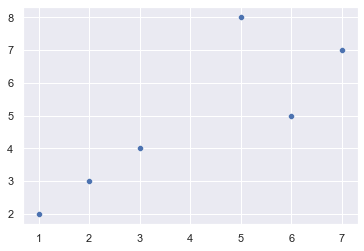

In [165]:
sns.scatterplot(x=[1,3,5,7,2,6],y=[2,4,8,7,3,5])

In [152]:
list(zip(v1,v2))

[(1, 2), (3, 4), (5, 8), (7, 7), (2, 3), (6, 5)]

In [153]:
mean_v1 = np.mean(v1)
mean_v2 = np.mean(v2)

In [154]:
nom = np.sum([(i1 - mean_v1)*(i2 - mean_v2) for i1,i2 in zip(v1,v2)])

In [155]:
denom = np.std(v1) * np.std(v2)*(len(v1))

In [156]:
nom / denom

0.8390957231764806

In [157]:
pd.Series(v1).corr(pd.Series(v2))

0.8390957231764807

In [158]:
v1_ranked = {v:i+1 for i,v in enumerate(sorted(v1))}
v1_rank = [v1_ranked[i] for i in v1]
v1_rank

[1, 3, 4, 6, 2, 5]

In [159]:
v2_ranked = {v:i+1 for i,v in enumerate(sorted(v2))}
v2_rank = [v2_ranked[i] for i in v2]
v2_rank

[1, 3, 6, 5, 2, 4]

In [160]:
mean_v1 = np.mean(v1_rank)
mean_v2 = np.mean(v2_rank)

In [161]:
nom = np.sum([(i1 - mean_v1)*(i2 - mean_v2) for i1,i2 in zip(v1_rank,v2_rank)])

In [162]:
denom = np.std(v1_rank) * np.std(v2_rank) * len(v2_rank)

In [163]:
nom/denom

0.8285714285714286

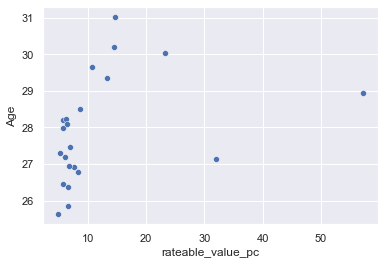

In [169]:
sns.scatterplot(x='rateable_value_pc',y='Age',data=data_merged)

In [164]:
pd.Series(v1).corr(pd.Series(v2),method='spearman')

0.8285714285714287

In [166]:
data_merged['rateable_value_pc'].corr(merged['Age'],method='pearson')

0.3543273581913075

In [167]:
data_merged['rateable_value_pc'].corr(merged['Age'],method='spearman')

0.5511591990565328

In [171]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc'])

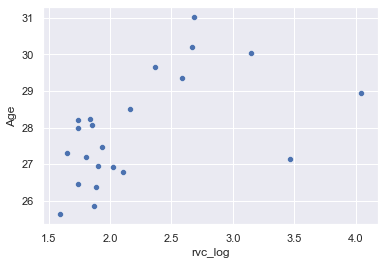

In [172]:
sns.scatterplot(x='rvc_log',y='Age',data=data_merged)

In [173]:
data_merged['rvc_log'].corr(merged['Age'],method='pearson')

0.5353983955320823

In [174]:
wo_outliers = data_merged[~data_merged.borough.isin(['Westminster',"Holborn"])]
wo_outliers['rvc_log'].corr(wo_outliers['Age'])

0.8055989190525027

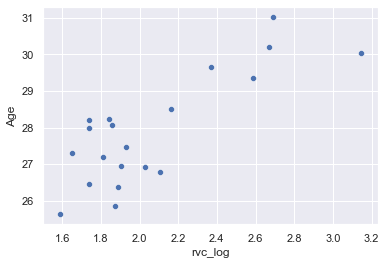

In [175]:
sns.scatterplot(x='rvc_log',y='Age',data=wo_outliers)

## Regression

If correlation is not causation, than what is?

Causal if intervening on one variable will predict changes behaviour in another.

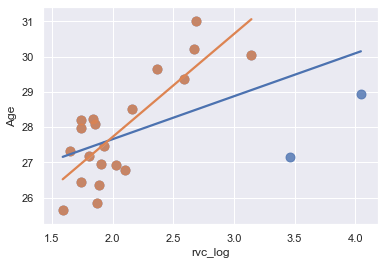

In [178]:
sns.regplot(x="rvc_log", y="Age", data=data_merged,
                 scatter_kws={"s": 80},
                 order=1,ci=False)

sns.regplot(x="rvc_log", y="Age", data=wo_outliers,
                 scatter_kws={"s": 80},
                 order=1,ci=False)

In [ ]:
sns.regplot(x="rvc_log", y="Age", data=data_merged,
                 scatter_kws={"s": 80},
                 order=1,ci=False)

In [ ]:
sns.regplot(x="rvc_log", y="Age", data=wo_outliers,
                 scatter_kws={"s": 80},
                 order=1,ci=False)

In [ ]:
sns.regplot(x="rvc_log", y="Age", data=data_merged,
                 scatter_kws={"s": 80},
                 order=2, ci=False)

In [179]:
Y = data_merged['Age']
X = data_merged['rvc_log']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [180]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     8.037
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0102
Time:                        22:20:24   Log-Likelihood:                -35.340
No. Observations:                  22   AIC:                             74.68
Df Residuals:                      20   BIC:                             76.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2161      0.992     25.420      0.000      23.147      27.285
rvc_log        1.2195      0.430      2.835      0.010       0.322       2.117
==============================================================================
Omnibus:                        0.454   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.797   Jarque-Bera (JB):                0.557
Skew:                           0.081   Prob(JB):                        0.757
Kurtosis:                       2.238   Cond. No.                         9.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
results.params

const      25.216130
rvc_log     1.219462
dtype: float64

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


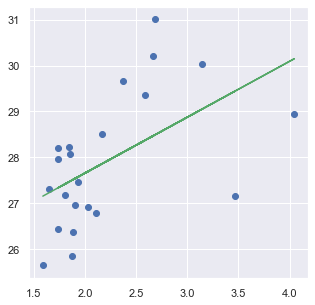

In [228]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
ax.plot(data_merged['rvc_log'], 25.216130 + (data_merged['rvc_log']*1.219462) , '-g')
#ax.avline(x = df_wh_F['Age'].mean() - df_wh_M['Age'].mean(), color='black', lw=2)

In [266]:
Y = wo_outliers['Age']
X = wo_outliers['rvc_log']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [270]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     33.28
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           1.82e-05
Time:                        22:54:00   Log-Likelihood:                -25.614
No. Observations:                  20   AIC:                             55.23
Df Residuals:                      18   BIC:                             57.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.8726      1.066     20.510      0.000      19.632      24.113
rvc_log        2.9228      0.507      5.769      0.000       1.858       3.987
==============================================================================
Omnibus:                        5.011   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                1.565
Skew:                          -0.104   Prob(JB):                        0.457
Kurtosis:                       1.645   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
results.params

const      21.872586
rvc_log     2.922830
dtype: float64

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


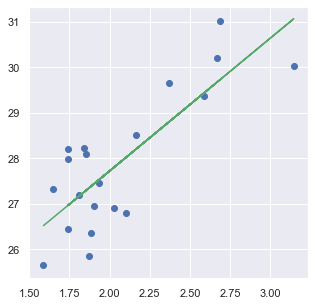

In [196]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=wo_outliers)
ax.plot(wo_outliers['rvc_log'], results.params['const'] + (wo_outliers['rvc_log']*results.params['rvc_log']) , '-g')
#ax.avline(x = df_wh_F['Age'].mean() - df_wh_M['Age'].mean(), color='black', lw=2)

In [273]:
wo_outliers['predictions'] = results.predict(X.values)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


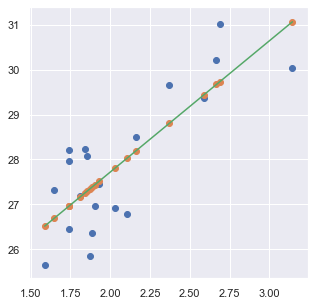

In [275]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=wo_outliers)
ax.scatter('rvc_log', 'predictions',data=wo_outliers)
ax.plot(wo_outliers['rvc_log'], results.params['const'] + (wo_outliers['rvc_log']*results.params['rvc_log']) , '-g')
#ax.avline(x = df_wh_F['Age'].mean() - df_wh_M['Age'].mean(), color='black', lw=2)

In [280]:
results.predict([[1.0,0],[1.0,2.5],[1.0,40]])

array([ 21.87258556,  29.17966008, 138.78577787])

In [211]:
Y = wo_outliers['Age']
x = wo_outliers['rvc_log']
X = np.column_stack((x, x ** 2,x ** 3))
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [212]:
results.params

const    68.117515
x1      -60.382076
x2       28.213160
x3       -4.086779
dtype: float64

array([[ 2.5       ,  3.97308801,  6.31417134, 10.03470339],
       [ 2.5       ,  4.12164656,  6.79518816, 11.20294557],
       [ 2.5       ,  4.35116544,  7.57305626, 13.18064827],
       [ 2.5       ,  4.35116544,  7.57305626, 13.18064827],
       [ 2.5       ,  4.35116544,  7.57305626, 13.18064827],
       [ 2.5       ,  4.52072193,  8.1747707 , 14.78234606],
       [ 2.5       ,  4.60137408,  8.46905738, 15.58772046],
       [ 2.5       ,  4.64074498,  8.61460557, 15.99127501],
       [ 2.5       ,  4.67950544,  8.75910847, 16.39531831],
       [ 2.5       ,  4.71767412,  8.90257965, 16.79978786],
       [ 2.5       ,  4.75526882,  9.0450326 , 17.20462459],
       [ 2.5       ,  4.82880353,  9.32693741, 18.01517931],
       [ 2.5       ,  5.07037062, 10.28346328, 20.85638803],
       [ 2.5       ,  5.26033539, 11.06845135, 23.28950652],
       [ 2.5       ,  5.40830756, 11.69991628, 25.31069829],
       [ 2.5       ,  5.92560935, 14.04513848, 33.29040159],
       [ 2.5       ,  6.

In [226]:
wo_outliers.sort_values('rvc_log',inplace=True)

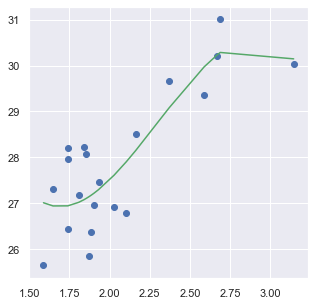

In [220]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=wo_outliers)
ax.plot(wo_outliers['rvc_log'],  
        results.params['const'] +  \
        (wo_outliers['rvc_log']*results.params['x1']) + \
        (np.power(wo_outliers['rvc_log'],2) * results.params['x2']) + \
        (np.power(wo_outliers['rvc_log'],3) * results.params['x3']) ,'-g')


## Predicting Counts

## Gender bias in university admissions?

In [281]:

data = pd.read_csv('/Users/kbeelen/Documents/OtherProjects/BayesianModelling/UCBadmit.csv',sep=';')
data.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [282]:
data['gid'] = pd.Categorical(data['applicant.gender']).codes 
data['did'] = pd.Categorical(data['dept']).codes 
data.head()

,dept,applicant.gender,admit,reject,applications,gid,did
1,A,male,512,313,825,1,0
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,0,1
5,C,male,120,205,325,1,2


In [283]:
data['gender'] = data['applicant.gender']

In [284]:
#https://timeseriesreasoning.com/contents/binomial-regression-model/


In [285]:
formula = 'admit +  reject ~ C(gender) + C(did)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                        5
Model Family:                 Binomial   Df Model:                            6
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -44.572
Date:                 Mon, 17 Jan 2022   Deviance:                       20.204
Time:                         23:02:32   Pearson chi2:                     18.8
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6819

In [286]:
data[['female','male']] = pd.get_dummies(data['applicant.gender'])

In [287]:
data

,dept,applicant.gender,admit,reject,applications,gid,did,gender,female,male
1,A,male,512,313,825,1,0,male,0,1
2,A,female,89,19,108,0,0,female,1,0
3,B,male,353,207,560,1,1,male,0,1
4,B,female,17,8,25,0,1,female,1,0
5,C,male,120,205,325,1,2,male,0,1
6,C,female,202,391,593,0,2,female,1,0
7,D,male,138,279,417,1,3,male,0,1
8,D,female,131,244,375,0,3,female,1,0
9,E,male,53,138,191,1,4,male,0,1
10,E,female,94,299,393,0,4,female,1,0


In [288]:
logistic(0.6104) - .5

NameError: name 'logistic' is not defined

In [155]:
logistic(-0.0999) -.5

-0.02495424981264921

In [171]:
formula = 'admit +  reject ~ female + male + C(did)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                        5
Model Family:                 Binomial   Df Model:                            6
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -44.572
Date:                 Sun, 09 Jan 2022   Deviance:                       20.204
Time:                         22:20:51   Pearson chi2:                     18.8
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4213      0.050      8

In [166]:
logistic(-0.4803)

0.38218128710219784

In [167]:
logistic(0.1301)

0.532479200978304

In [182]:
logit = lambda  p:  np.log(p / (1 - p))

In [183]:
logistic = lambda lt: np.exp(lt) / (np.exp(lt) + 1)

In [188]:
round(logistic(logit(.6)),2)

0.6

In [185]:
exp()

NameError: name 'exp' is not defined

In [168]:
logistic(-0.4803) - logistic(0.1301)

-0.1502979138761062

In [195]:
logistic(-0.2606) - .5

-0.0647837793686441

In [ ]:
formula = 'admit +  reject ~ female + male'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

In [158]:
logistic(- 2.6526) -.5

-0.4341710593886168

In [15]:
exog = data[['gid','did','applications']].values
exog

array([[  1,   0, 825],
       [  0,   0, 108],
       [  1,   1, 560],
       [  0,   1,  25],
       [  1,   2, 325],
       [  0,   2, 593],
       [  1,   3, 417],
       [  0,   3, 375],
       [  1,   4, 191],
       [  0,   4, 393],
       [  1,   5, 373],
       [  0,   5, 341]])

In [ ]:
endog = data[]

## Gender and parliamentary questions

In [3]:
#!pip3 install seaborn==0.11.2

In [204]:
df = pd.read_csv('data/questions/parl_questions.csv',index_col=0,
                 parse_dates=["dob",'date tabled'],
                date_parser= lambda x: pd.to_datetime(x, format="%Y-%m-%"))

In [205]:
df.head()

,uri,answer date,answer date time,answering body,commons question time > question type,location > pref label,question status,ballot number,date tabled,modified,...,tabling member > uri,tabling member > constituency > pref label,tabling member printed,uin,tabling member,gender,party,uri_mp,dob,uri_dob
0,http://data.parliament.uk/resources/1388433,2022-01-05,2022-01-05T00:00:00,Prime Minister,Substantive,House of Commons chamber,Tabled,5,2021-12-16,2021-12-16T14:51:06.915,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904884.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
1,http://data.parliament.uk/resources/1386494,2021-12-15,2021-12-15T00:00:00,Prime Minister,Substantive,House of Commons chamber,Tabled,9,2021-12-09,2021-12-15T09:09:06.008,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904812.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
2,http://data.parliament.uk/resources/1379254,2021-11-23,2021-11-23T00:00:00,Department of Health and Social Care,Topical,House of Commons chamber,Tabled,10,2021-11-17,2021-11-23T13:44:07.090,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904329.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
3,http://data.parliament.uk/resources/1351922,2021-09-06,2021-09-06T00:00:00,Department for Education,Substantive,House of Commons chamber,Tabled,9,2021-08-31,2021-09-06T15:32:44.687,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,903323.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
4,http://data.parliament.uk/resources/1347152,2021-07-22,2021-07-22T00:00:00,"Department for Environment, Food and Rural Aff...",Substantive,House of Commons chamber,Tabled,13,2021-07-15,2021-08-18T17:06:49.789,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,903142.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601


In [206]:
df.shape

(36748, 22)

In [207]:
df['uri_mp'].unique().shape

(740,)

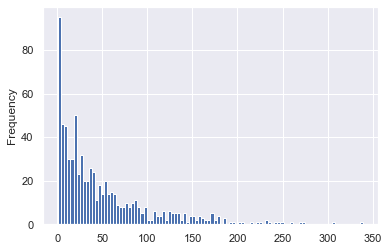

In [208]:
df.groupby('uri_mp')['uri'].count().plot(kind='hist',bins=100)

In [209]:
df.groupby(['uri_mp','answering body'])['uri'].count().groupby(level=0).apply(lambda x: x / x.sum())

uri_mp                                 answering body                              
http://data.parliament.uk/members/103  Department of Health and Social Care            0.500000
                                       Prime Minister                                  0.500000
http://data.parliament.uk/members/104  Department of Health and Social Care            0.071429
                                       Foreign and Commonwealth Office                 0.071429
                                       Foreign, Commonwealth and Development Office    0.071429
                                                                                         ...   
http://data.parliament.uk/members/93   HM Treasury                                     0.050000
                                       Home Office                                     0.025000
                                       Ministry of Defence                             0.050000
                                       Ministry of J

In [222]:
data_parl = df.groupby(['uri_mp','gender','party','answering body'])['uri'].count()
data_parl= data_parl.reset_index()
data_parl

,uri_mp,gender,party,answering body,uri
0,http://data.parliament.uk/members/103,Male,Conservative,Department of Health and Social Care,1
1,http://data.parliament.uk/members/103,Male,Conservative,Prime Minister,1
2,http://data.parliament.uk/members/104,Male,Conservative,Department of Health and Social Care,1
3,http://data.parliament.uk/members/104,Male,Conservative,Foreign and Commonwealth Office,1
4,http://data.parliament.uk/members/104,Male,Conservative,"Foreign, Commonwealth and Development Office",1
...,...,...,...,...,...
10984,http://data.parliament.uk/members/93,Male,Conservative,HM Treasury,2
10985,http://data.parliament.uk/members/93,Male,Conservative,Home Office,1
10986,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Defence,2
10987,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Justice,2


In [226]:
by_mp = df.groupby(['uri_mp'])['uri'].count()

In [227]:
data_parl = data_parl.merge(by_mp, left_on='uri_mp', right_index=True)

In [228]:
data_parl

,uri_mp,gender,party,answering body,uri_x,uri_y
0,http://data.parliament.uk/members/103,Male,Conservative,Department of Health and Social Care,1,2
1,http://data.parliament.uk/members/103,Male,Conservative,Prime Minister,1,2
2,http://data.parliament.uk/members/104,Male,Conservative,Department of Health and Social Care,1,14
3,http://data.parliament.uk/members/104,Male,Conservative,Foreign and Commonwealth Office,1,14
4,http://data.parliament.uk/members/104,Male,Conservative,"Foreign, Commonwealth and Development Office",1,14
...,...,...,...,...,...,...
10984,http://data.parliament.uk/members/93,Male,Conservative,HM Treasury,2,40
10985,http://data.parliament.uk/members/93,Male,Conservative,Home Office,1,40
10986,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Defence,2,40
10987,http://data.parliament.uk/members/93,Male,Conservative,Ministry of Justice,2,40


In [252]:
data_parl['not_body'] = data_parl['uri_y'] -  data_parl['uri_x'] 

In [253]:
data_parl['answering body'].unique()

array(['Department of Health and Social Care', 'Prime Minister',
       'Foreign and Commonwealth Office',
       'Foreign, Commonwealth and Development Office', 'Home Office',
       'Ministry of Defence', 'Women and Equalities',
       'Department for Communities and Local Government',
       'Department for Education',
       'Department for Environment, Food and Rural Affairs',
       'Department of Health', 'Attorney General', 'COP26',
       'Cabinet Office', 'Church Commissioners',
       'Department for Business, Energy and Industrial Strategy',
       'Department for Business, Innovation and Skills',
       'Department for Culture, Media and Sport',
       'Department for Digital, Culture, Media and Sport',
       'Department for Energy and Climate Change',
       'Department for Exiting the European Union ',
       'Department for International Development',
       'Department for International Trade', 'Department for Transport',
       'Department for Work and Pensions', 'De

In [285]:
body = 'Department for Energy and Climate Change'#'Department for Exiting the European Union'#'Ministry of Defence'# 'Women and Equalities'
df_body = data_parl[(data_parl['answering body']==body) & (data_parl.party.isin(['Conservative','Labour']))]
df_body

,uri_mp,gender,party,answering body,uri_x,uri_y,not_body
23,http://data.parliament.uk/members/114,Male,Conservative,Department for Energy and Climate Change,1,118,117
50,http://data.parliament.uk/members/116,Male,Conservative,Department for Energy and Climate Change,1,34,33
100,http://data.parliament.uk/members/12,Female,Labour,Department for Energy and Climate Change,1,52,51
136,http://data.parliament.uk/members/136,Male,Conservative,Department for Energy and Climate Change,4,10,6
142,http://data.parliament.uk/members/1383,Male,Labour,Department for Energy and Climate Change,1,17,16
...,...,...,...,...,...,...,...
10880,http://data.parliament.uk/members/605,Male,Labour,Department for Energy and Climate Change,7,37,30
10900,http://data.parliament.uk/members/62,Male,Labour,Department for Energy and Climate Change,4,24,20
10916,http://data.parliament.uk/members/636,Female,Labour,Department for Energy and Climate Change,1,16,15
10936,http://data.parliament.uk/members/69,Male,Conservative,Department for Energy and Climate Change,1,35,34


In [307]:
formula = 'uri_x + not_body ~ C(gender) + C(party)'
mod1 = smf.glm(formula=formula, data=df_body, family=sm.families.Binomial()).fit()
print(mod1.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     ['uri_x', 'not_body']   No. Observations:                  212
Model:                               GLM   Df Residuals:                      209
Model Family:                   Binomial   Df Model:                            2
Link Function:                     logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -432.52
Date:                   Sun, 09 Jan 2022   Deviance:                       329.35
Time:                           23:16:11   Pearson chi2:                     523.
No. Iterations:                        7                                         
Covariance Type:               nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [301]:
mod1.pvalues

Intercept             7.687015e-231
gender[T.Male]         2.308249e-01
C(party)[T.Labour]     1.504530e-02
dtype: float64

In [302]:
print(logistic(mod1.params['gender[T.Male]']) - .5)
#print(logistic(-0.567) - .5,logistic(-0.256) - .5)

0.03196124921406451


AttributeError: 'GLMResults' object has no attribute 'mse_resid'

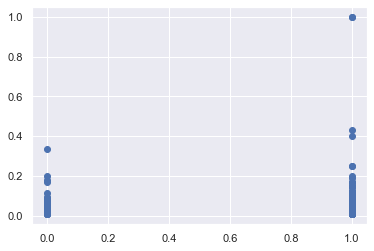

In [311]:
fig = sm.graphics.plot_fit(mod1, "C(gender)[T.Male]")
fig.tight_layout(pad=1.0)

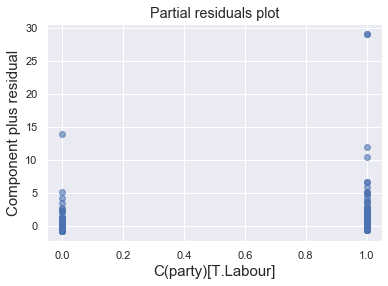

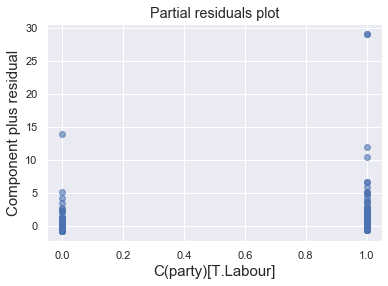

In [306]:
mod1.plot_partial_residuals('C(party)[T.Labour]')

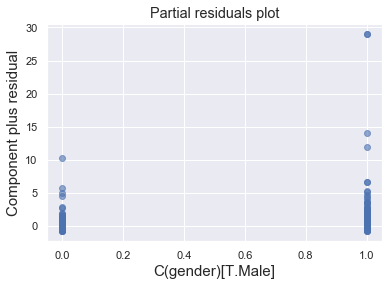

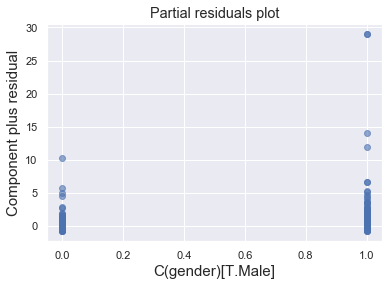

In [308]:
mod1.plot_partial_residuals('C(gender)[T.Male]')

In [289]:
formula = 'uri_x ~ C(gender) + C(party)'
mod1 = smf.glm(formula=formula, data=df_body, family=sm.families.Poisson(), exposure=df_body['uri_y']).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  uri_x   No. Observations:                  212
Model:                            GLM   Df Residuals:                      209
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -430.67
Date:                Sun, 09 Jan 2022   Deviance:                       310.23
Time:                        23:11:37   Pearson chi2:                     506.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.7143      0

In [245]:
logistic(-0.3632) - .5

-0.08981484250963839

In [242]:
logistic(-0.3565) - .5

-0.08819291949925195

In [235]:
df.groupby(['uri_mp','gender'])['answering body'].apply(lambda x: len(set(x)))

uri_mp                                 gender
http://data.parliament.uk/members/103  Male       2
http://data.parliament.uk/members/104  Male       7
http://data.parliament.uk/members/111  Male       4
http://data.parliament.uk/members/114  Male      33
http://data.parliament.uk/members/116  Male      16
                                                 ..
http://data.parliament.uk/members/69   Male      19
http://data.parliament.uk/members/76   Male      10
http://data.parliament.uk/members/77   Male       2
http://data.parliament.uk/members/87   Male      12
http://data.parliament.uk/members/93   Male      15
Name: answering body, Length: 740, dtype: int64

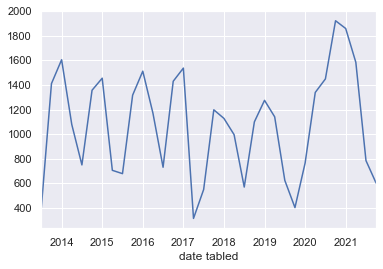

In [54]:
df.set_index('date tabled').resample('Q')['uri'].count().plot()

In [28]:
get_age = lambda x: 2021 - x.year
df['age'] = df['dob'].apply(get_age)

In [29]:
members = df[['age','party','gender']].drop_duplicates()

gender
Female    AxesSubplot(0.125,0.125;0.775x0.755)
Male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

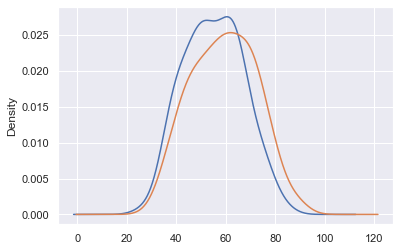

In [30]:
members.groupby('gender')['age'].plot(kind='density')

In [32]:
members[['age','gender']]

,age,gender
0,69,Male
87,52,Male
290,63,Male
335,43,Male
404,59,Male
...,...,...
36719,70,Male
36728,75,Male
36735,51,Male
36740,58,Female


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


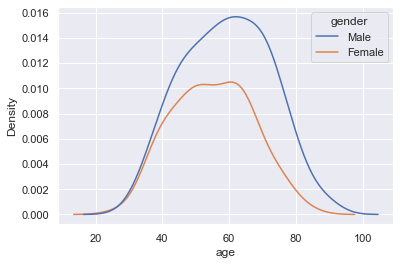

In [33]:
sns.kdeplot(x='age',hue='gender',data=members[['age','gender']])

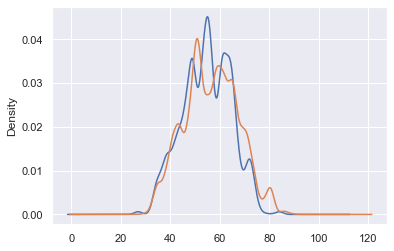

In [36]:
df[df.gender=='Female']['age'].plot(kind='density')
df[df.gender=='Male']['age'].plot(kind='density')

In [37]:
df.groupby(['answering body','gender'])

In [38]:
%matplotlib inline
by_gender = df.groupby(['answering body','gender'])['date tabled'].count()#.reset_index()
by_gender

answering body        gender
Attorney General      Female    224
                      Male      455
COP26                 Female     51
                      Male      112
Cabinet Office        Female    390
                               ... 
Treasury              Male      557
Wales Office          Female    184
                      Male      660
Women and Equalities  Female    440
                      Male      552
Name: date tabled, Length: 83, dtype: int64

In [39]:
probs = by_gender.groupby(level=1).apply(lambda x: x / float(x.sum()))
probs_df = probs.reset_index()

In [40]:
probs_df

,answering body,gender,date tabled
0,Attorney General,Female,0.019846
1,Attorney General,Male,0.017870
2,COP26,Female,0.004518
3,COP26,Male,0.004399
4,Cabinet Office,Female,0.034553
...,...,...,...
78,Treasury,Male,0.021877
79,Wales Office,Female,0.016302
80,Wales Office,Male,0.025922
81,Women and Equalities,Female,0.038983


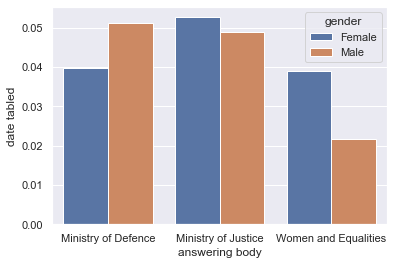

In [41]:
domains = ['Women and Equalities','Ministry of Defence','Ministry of Justice']
sns.barplot(x="answering body", y="date tabled", hue='gender', data=probs_df[probs_df['answering body'].isin(domains)])

In [24]:
by_gender.plot('')

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='')` instead of `Series.plot('',)`.

In [26]:
df.groupby('gender')['age'].mad()

gender
Female    6.856617
Male      7.906342
Name: age, dtype: float64

In [1]:
df

NameError: name 'df' is not defined

In [37]:
by_mp = df.groupby(['uri_mp','answering body'])['uri'].count()
by_mp[:,'Ministry of Justice']

uri_mp
http://data.parliament.uk/members/114     7
http://data.parliament.uk/members/1170    1
http://data.parliament.uk/members/1198    8
http://data.parliament.uk/members/12      4
http://data.parliament.uk/members/1387    4
                                         ..
http://data.parliament.uk/members/602     4
http://data.parliament.uk/members/605     1
http://data.parliament.uk/members/69      1
http://data.parliament.uk/members/87      1
http://data.parliament.uk/members/93      2
Name: uri, Length: 437, dtype: int64

In [38]:
by_mp[:,'Ministry of Justice']

uri_mp
http://data.parliament.uk/members/114     7
http://data.parliament.uk/members/1170    1
http://data.parliament.uk/members/1198    8
http://data.parliament.uk/members/12      4
http://data.parliament.uk/members/1387    4
                                         ..
http://data.parliament.uk/members/602     4
http://data.parliament.uk/members/605     1
http://data.parliament.uk/members/69      1
http://data.parliament.uk/members/87      1
http://data.parliament.uk/members/93      2
Name: uri, Length: 437, dtype: int64

In [39]:
by_mp.groupby(['uri_mp']).sum()

uri_mp
http://data.parliament.uk/members/103      2
http://data.parliament.uk/members/104     14
http://data.parliament.uk/members/111      5
http://data.parliament.uk/members/114    118
http://data.parliament.uk/members/116     34
                                        ... 
http://data.parliament.uk/members/69      35
http://data.parliament.uk/members/76      23
http://data.parliament.uk/members/77       3
http://data.parliament.uk/members/87      21
http://data.parliament.uk/members/93      40
Name: uri, Length: 740, dtype: int64

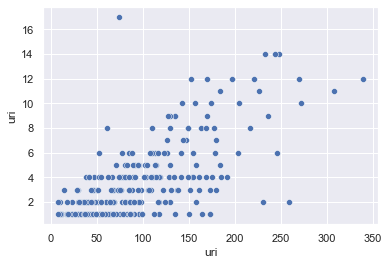

In [40]:
sns.scatterplot(x=by_mp.groupby(level=0).sum(),y=by_mp[:,'Women and Equalities'])

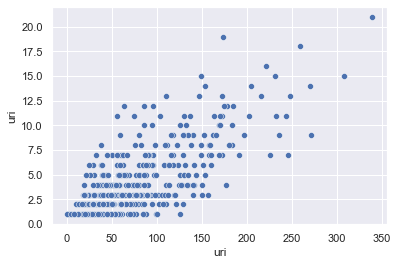

In [41]:
sns.scatterplot(x=by_mp.groupby(level=0).sum(),y=by_mp[:,'Ministry of Justice'])

In [56]:
by_mp = df.groupby(['uri_mp','answering body','gender'])['uri'].count()
#by_mp['t_count'] = df.groupby(['uri_mp','','gender'])['uri'].count()

In [61]:
by_mp_row = by_mp.unstack(level=1)

In [63]:
by_mp_row.fillna(0,inplace=True)


,answering body,Attorney General,COP26,Cabinet Office,Chancellor of the Duchy of Lancaster,Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office,Church Commissioners,"Department for Business, Energy and Industrial Strategy","Department for Business, Innovation and Skills",Department for Communities and Local Government,"Department for Culture, Media and Sport",...,Ministry of Justice,Northern Ireland Office,Parliamentary Works Sponsor Body,Prime Minister,Public Accounts Commission,Scotland Office,Speaker's Committee on the Electoral Commission,Treasury,Wales Office,Women and Equalities
uri_mp,gender,,,,,,,,,,,,,,,,,,,,,
http://data.parliament.uk/members/103,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
http://data.parliament.uk/members/104,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0
http://data.parliament.uk/members/111,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://data.parliament.uk/members/114,Male,7.0,1.0,4.0,0.0,0.0,5.0,4.0,1.0,2.0,1.0,...,7.0,2.0,0.0,13.0,0.0,2.0,0.0,4.0,2.0,1.0
http://data.parliament.uk/members/116,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://data.parliament.uk/members/69,Male,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,1.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
http://data.parliament.uk/members/76,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
http://data.parliament.uk/members/77,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
by_mp_row['all'] = by_mp_row.sum(axis=1)

In [75]:
by_mp_row = by_mp_row.reset_index()

In [76]:
by_mp_row['gender']

0      Male
1      Male
2      Male
3      Male
4      Male
       ... 
735    Male
736    Male
737    Male
738    Male
739    Male
Name: gender, Length: 740, dtype: object

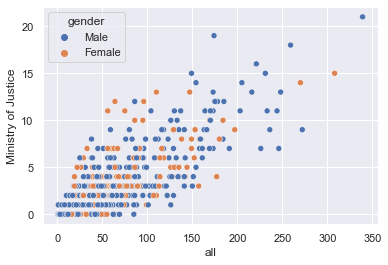

In [77]:
sns.scatterplot(x='all',y='Ministry of Justice',hue='gender',data=by_mp_row)

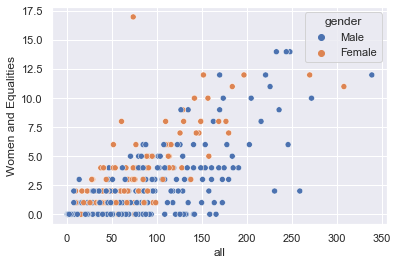

In [78]:
sns.scatterplot(x='all',y='Women and Equalities',hue='gender',data=by_mp_row)

In [90]:
import numpy as np


array([[  2.],
       [ 14.],
       [  5.],
       [118.],
       [ 34.],
       [  2.],
       [ 11.],
       [  4.],
       [  4.],
       [  2.],
       [ 76.],
       [ 52.],
       [  8.],
       [  8.],
       [  3.],
       [  2.],
       [ 16.],
       [ 10.],
       [  1.],
       [ 17.],
       [ 22.],
       [ 15.],
       [ 77.],
       [  1.],
       [  1.],
       [ 64.],
       [  7.],
       [ 22.],
       [ 10.],
       [ 53.],
       [ 32.],
       [  4.],
       [  1.],
       [102.],
       [ 20.],
       [ 24.],
       [ 23.],
       [ 28.],
       [  1.],
       [  5.],
       [ 48.],
       [  1.],
       [  9.],
       [  1.],
       [ 61.],
       [ 25.],
       [ 34.],
       [  7.],
       [ 14.],
       [ 10.],
       [ 21.],
       [161.],
       [180.],
       [  7.],
       [ 78.],
       [173.],
       [ 11.],
       [  9.],
       [ 94.],
       [ 56.],
       [ 20.],
       [  5.],
       [  4.],
       [  4.],
       [  9.],
       [ 37.],
       [ 1

In [91]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.array(by_mp_row['all'])[...,np.newaxis], np.array(by_mp_row['Women and Equalities'])[...,np.newaxis])



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [99]:
pd.DataFrame(by_mp_row['Women and Equalities']).assign(const=1)

,Women and Equalities,const
0,0.0,1
1,3.0,1
2,0.0,1
3,1.0,1
4,0.0,1
...,...,...
735,0.0,1
736,0.0,1
737,0.0,1
738,0.0,1


In [101]:
import statsmodels.api as sm

model = sm.OLS(np.array(by_mp_row['Women and Equalities']), pd.DataFrame(by_mp_row['all']).assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     1004.
Date:                Mon, 27 Dec 2021   Prob (F-statistic):          8.70e-140
Time:                        11:26:20   Log-Likelihood:                -1411.6
No. Observations:                 740   AIC:                             2827.
Df Residuals:                     738   BIC:                             2836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
all            0.0356      0.001     31.688      0.000       0.033       0.038
const         -0.4295      0.082     -5.239      0.000      -0.590      -0.269
==============================================================================
Omnibus:                      293.549   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4534.645
Skew:                           1.356   Prob(JB):                         0.00
Kurtosis:                      14.820   Cond. No.                         99.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
model.coef_

array([[0.03564446]])

In [93]:
model.intercept_

array([-0.42954414])

In [106]:
by_mp_row[:10]

answering body,uri_mp,gender,Attorney General,COP26,Cabinet Office,Chancellor of the Duchy of Lancaster,Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office,Church Commissioners,"Department for Business, Energy and Industrial Strategy","Department for Business, Innovation and Skills",...,Northern Ireland Office,Parliamentary Works Sponsor Body,Prime Minister,Public Accounts Commission,Scotland Office,Speaker's Committee on the Electoral Commission,Treasury,Wales Office,Women and Equalities,all
0,http://data.parliament.uk/members/103,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,http://data.parliament.uk/members/104,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,14.0
2,http://data.parliament.uk/members/111,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,http://data.parliament.uk/members/114,Male,7.0,1.0,4.0,0.0,0.0,5.0,4.0,1.0,...,2.0,0.0,13.0,0.0,2.0,0.0,4.0,2.0,1.0,118.0
4,http://data.parliament.uk/members/116,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.0
5,http://data.parliament.uk/members/1166,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
6,http://data.parliament.uk/members/117,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
7,http://data.parliament.uk/members/1170,Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
8,http://data.parliament.uk/members/1171,Male,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
9,http://data.parliament.uk/members/1191,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [121]:
by_mp_row.corr()['all']

answering body
Attorney General                                                            0.768516
COP26                                                                       0.495064
Cabinet Office                                                              0.827445
Chancellor of the Duchy of Lancaster                                        0.080351
Chancellor of the Duchy of Lancaster and Minister for the Cabinet Office    0.361069
Church Commissioners                                                        0.483297
Department for Business, Energy and Industrial Strategy                     0.778503
Department for Business, Innovation and Skills                              0.511141
Department for Communities and Local Government                             0.564158
Department for Culture, Media and Sport                                     0.594660
Department for Digital, Culture, Media and Sport                            0.779572
Department for Education                          

In [108]:
X = pd.get_dummies(by_mp_row[['gender','Women and Equalities','all']],drop_first=True)
X

,Women and Equalities,all,gender_Male
0,0.0,2.0,1
1,3.0,14.0,1
2,0.0,5.0,1
3,1.0,118.0,1
4,0.0,34.0,1
...,...,...,...
735,0.0,35.0,1
736,0.0,23.0,1
737,0.0,3.0,1
738,0.0,21.0,1


In [110]:
model = sm.OLS(np.array(X['Women and Equalities']), pd.DataFrame(X[['all','gender_Male']]).assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     553.6
Date:                Mon, 27 Dec 2021   Prob (F-statistic):          1.61e-147
Time:                        11:31:32   Log-Likelihood:                -1390.1
No. Observations:                 740   AIC:                             2786.
Df Residuals:                     737   BIC:                             2800.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
all             0.0354      0.001     32.380      0.000       0.033       0.038
gender_Male    -0.8538      0.128     -6.652      0.000      -1.106      -0.602
const           0.1863      0.122      1.525      0.128      -0.053       0.426
==============================================================================
Omnibus:                      288.294   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4105.441
Skew:                           1.348   Prob(JB):                         0.00
Kurtosis:                      14.220   Cond. No.                         208.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
X = pd.get_dummies(by_mp_row[['gender','COP26','all']],drop_first=True)
model = sm.OLS(np.array(X['COP26']), pd.DataFrame(X[['all','gender_Male']]).assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     119.6
Date:                Mon, 27 Dec 2021   Prob (F-statistic):           1.01e-45
Time:                        11:32:55   Log-Likelihood:                -605.83
No. Observations:                 740   AIC:                             1218.
Df Residuals:                     737   BIC:                             1231.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
all             0.0059      0.000     15.460      0.000       0.005       0.007
gender_Male    -0.0009      0.044     -0.020      0.984      -0.088       0.086
const          -0.0701      0.042     -1.656      0.098      -0.153       0.013
==============================================================================
Omnibus:                      525.377   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8575.405
Skew:                           3.030   Prob(JB):                         0.00
Kurtosis:                      18.537   Cond. No.                         208.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
df.groupby('uri_mp')['uri'].count()

uri_mp
http://data.parliament.uk/members/103      2
http://data.parliament.uk/members/104     14
http://data.parliament.uk/members/111      5
http://data.parliament.uk/members/114    118
http://data.parliament.uk/members/116     34
                                        ... 
http://data.parliament.uk/members/69      35
http://data.parliament.uk/members/76      23
http://data.parliament.uk/members/77       3
http://data.parliament.uk/members/87      21
http://data.parliament.uk/members/93      40
Name: uri, Length: 740, dtype: int64

In [116]:
from statsmodels.discrete.discrete_model import NegativeBinomial

In [118]:
X = pd.get_dummies(by_mp_row[['gender','Women and Equalities','all']],drop_first=True)
model = NegativeBinomial(np.array(X['Women and Equalities']), pd.DataFrame(X[['all','gender_Male']]).assign(const=1))
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 1.187442
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  740
Model:               NegativeBinomial   Df Residuals:                      737
Method:                           MLE   Df Model:                            2
Date:                Mon, 27 Dec 2021   Pseudo R-squ.:                  0.2028
Time:                        11:36:50   Log-Likelihood:                -878.71
converged:                       True   LL-Null:                       -1102.2
Covariance Type:            nonrobust   LLR p-value:                 8.382e-98
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
all             0.0199      0.001     19.782      0.000       0.018       0.022
gender_Male    -0.8209      0.105     -7.786      0.000      -1.028      -0.614
const          -0.8186      0.108     -7.607      0.000      -1.030      -0.608
alpha           0.6153      0.093      6.582      0.000       0.432       0.799
===============================================================================
"""

In [131]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
X = pd.get_dummies(by_mp_row[['gender','Women and Equalities','all']],drop_first=True)
X.columns = ['response','all','gender']
X

,response,all,gender
0,0.0,2.0,1
1,3.0,14.0,1
2,0.0,5.0,1
3,1.0,118.0,1
4,0.0,34.0,1
...,...,...,...
735,0.0,35.0,1
736,0.0,23.0,1
737,0.0,3.0,1
738,0.0,21.0,1


In [137]:
model = smf.glm(formula='response ~ gender + all', data=X, family=sm.families.NegativeBinomial())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               response   No. Observations:                  740
Model:                            GLM   Df Residuals:                      737
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -884.37
Date:                Mon, 27 Dec 2021   Deviance:                       522.56
Time:                        12:00:25   Pearson chi2:                     595.
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9093      0.113     -8.039      0.000      -1.131      -0.688
gender        -0.8269      0.121     -6.834      0.000      -1.064      -0.590
all            0.0211      0.001     23.369      0.000       0.019       0.023
==============================================================================
"""

In [145]:
-np.exp(0.8269) * 100

-228.62204601880202

In [141]:
np.exp(0.0211)

1.0213241789489729

In [119]:
np.exp(-0.8209)

0.4400354443382635